这节课讲DeepLabv3+模型，及前身DeepLabv3模型，两篇论文来自Google的同一个团队。

参考资料
- [DeepLabv3+](https://arxiv.org/abs/1802.02611)，被引1000+
- [DeepLabv3](https://arxiv.org/abs/1706.05587)，被引1000+
- [Pytorch DeepLabv3+实现](https://github.com/jfzhang95/pytorch-deeplab-xception)，Star 1.5k

我们讲1.模型原理2.代码实现

In [6]:
import torch
import torch.nn as nn
from PIL import Image
from IPython import display

## 第一部分，模型原理

1. 背景知识
2. 整体架构

### 背景知识

图像任务中捕捉**多尺度的图像信息**很重要。通常有以下几种网络结构：
- 图a : 一个相同的网络，共享权重，应用到不同尺度的图片上提取特征。对于尺寸小的图片输入，提取全局图像信息；对于尺寸大的图片输入，提取局部图像信息。最后将多尺度的图像信息融合。
- 图b : 包含两个部分，下采样部分中图片尺寸逐层降低，浅层提取局部图像信息，深层提取全局图像信息；上采样中多尺度的图片特征合并，逐层还原图片尺寸。
- 图c : 
- 图d : SPP层采用多个不同比率（rate）的Atrous convolution，并行作用在特征图上，比率（rate）较大的卷积提取相对全局信息，较小的卷积提取相对局部的信息，最后将多个特征图进行合并。下面介绍"Atrous convolution"。


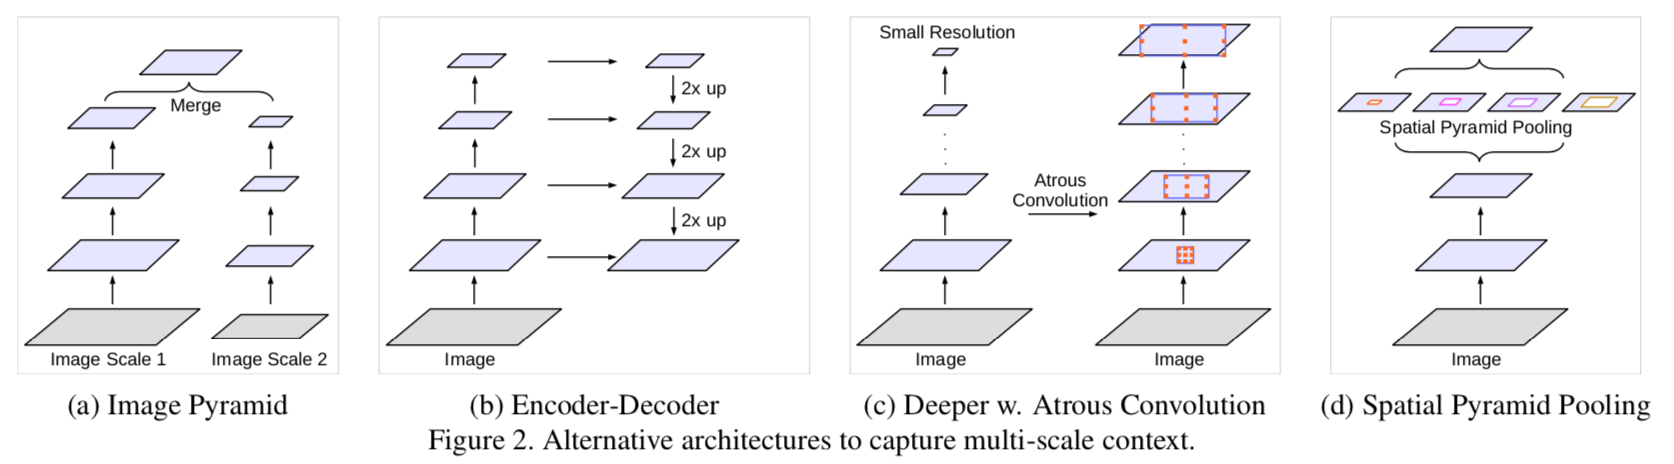

In [7]:
Image.open("assets/fig6.png")

什么是"Atrous convolution"？（又叫"dilated convolution"，回忆我们在pytorch的conv2d中的参数dilation=1）
- 一个卷积核中，相邻两个元素之间存在间隔，间隙中存在几个空白的元素，权重为0，不对图像做卷积
- 假如一个$3\times3$的卷积，dilation rate分别为1、6、24，这三个卷积核内同样包含9个元素，对图像做9个像素点的计算
- 不额外增加计算量
- dilation rate越大，扩大了卷积核的视野范围
- dilation rate=1时就是我们常用的标准卷积核
- 多种dilation rate的卷积核能够捕捉多种尺度下的物体特征

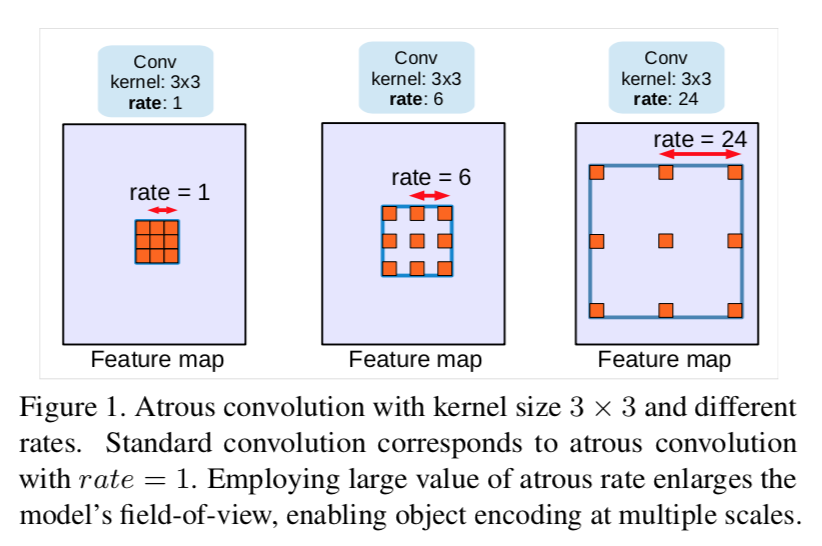

In [8]:
Image.open("assets/fig0.png")

In [9]:
display.Image(url='assets/fig5.gif')

In [10]:
conv = nn.Conv2d(1, 1, kernel_size=(3,3), dilation=2)
conv.weight

Parameter containing:
tensor([[[[-0.2536, -0.1592, -0.0577],
          [-0.2784, -0.1091,  0.1787],
          [ 0.3232, -0.1549, -0.1666]]]], requires_grad=True)

In [11]:
image = torch.ones((1, 1, 7, 7))
conv(image)

tensor([[[[-1.0096, -1.0096, -1.0096],
          [-1.0096, -1.0096, -1.0096],
          [-1.0096, -1.0096, -1.0096]]]], grad_fn=<SlowConvDilated2DBackward>)

什么叫"ASPP"模块？
- 多个不同比率（rate）的Atrous convolution作用在特征图上，提取多尺度下图像特征，进行合并的结构叫做"ASPP"模块。例如下图中 a、c 中，全称"Spatial Pyramid Pooling"。

DeepLabv3网络结构是什么？下图（a）
- 输入图片先进入Encoder层提取特征
- 对特征图进行Atrous convolution操作，提取多尺度特征图后合并（ASPP模块）
- 模型学习到的图像分割其实是在降低8倍分辨率图片上进行的
- 还原图像尺寸输出Mask（比率8倍，例如$64\times8=512$）

DeepLabv3改进点：
- 借鉴UNet等Encoder-Decoder结构中Skip Connection思想，将更多底层特征图融入到Decoder中

DeepLabv3+网络结构是什么？下图（c）
- 整体结构与DeepLabv3雷同，设计新的Decoder结构
- Decoder中先将ASPP模块特征图还原4倍
- 将Ecoder中底层特征图与Decoder中特征图合并
- 将合并后特征图还原4倍，输出Mask

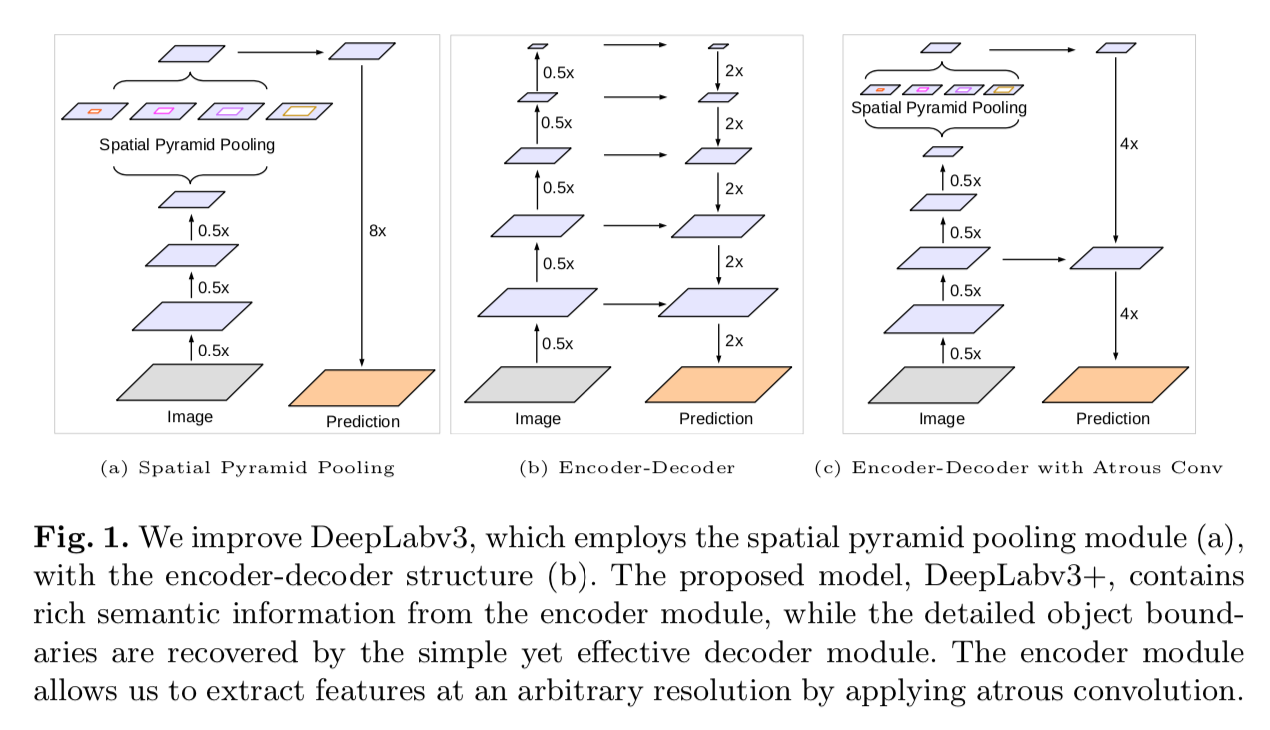

In [12]:
Image.open('assets/fig1.png')

### 整体架构

- 输入图片，进入Ecoder层提取特征图，作者使用Resnet101、Modified Aligned Xception
- 进入ASPP模块，作者使用1个$1\times1$卷积、3个$3\times3$的Atrous convolution分别比率为6、12、18，以及一个图像全局的Pooling操作（为了克服当比率较大时Atrous convolution，有效的卷积越来越少，导致效果不好）
- 合并Ecoder特征图，使用一个$1\times1$的卷积
- 上采样4倍
- 对底层特征图加一个$1\times1$的卷积降低channel数，与Encoder特征图合并，进入$3\times3$卷积层矫正分割效果（底层特征图通常256、512层，与Encoder特征图合并中层数占比过高，减损了Encoder特征图丰富的信息）
- 将分割上采样4倍还原图像尺寸

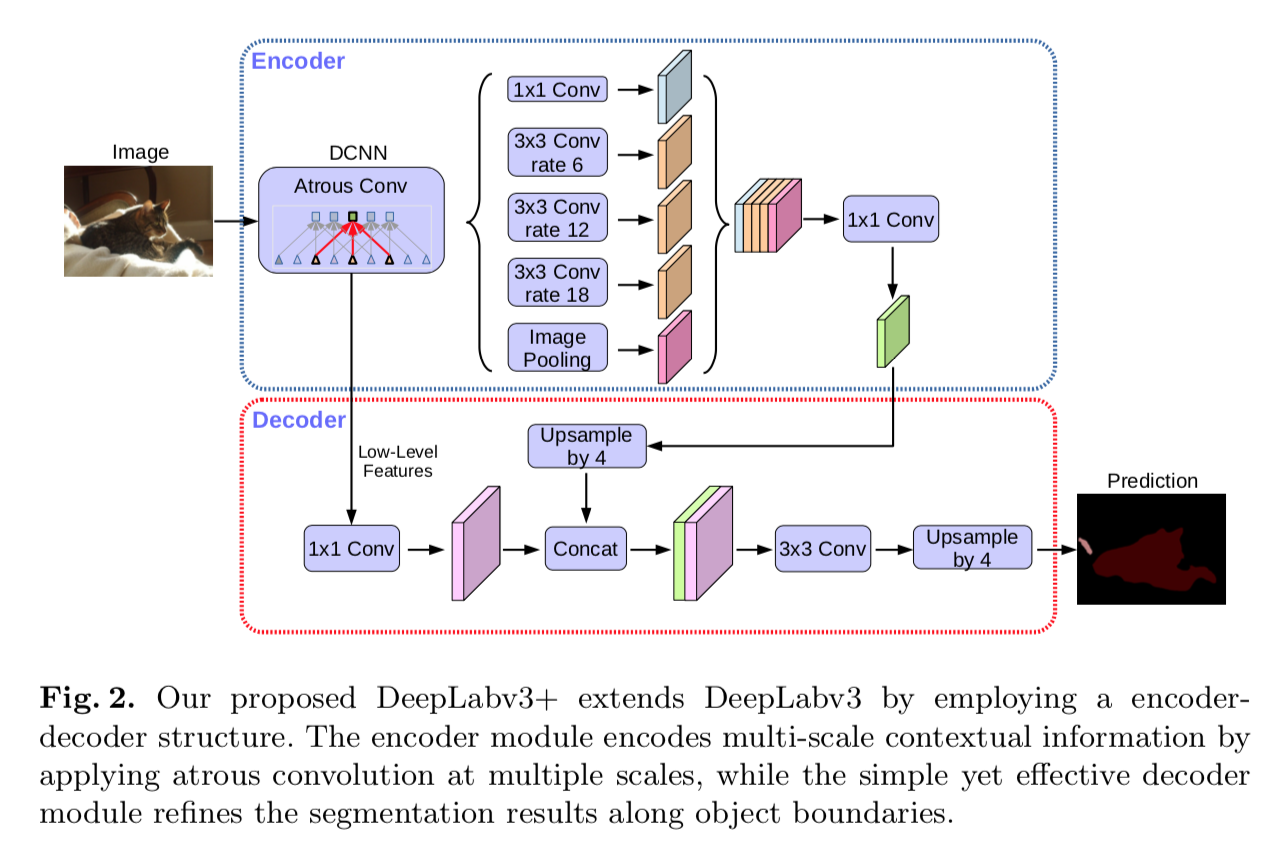

In [13]:
Image.open('assets/fig2.png')

还有一个细节需要注意。  
**Depthwise separable convolution**是什么？

- 图（a）一个$3\times3$的卷积作用在每一个channel上，计算后每一个channel在每一个像素点位置上得到一个数值。几何平面内的操作。
- 图（b）将所有channel的每一个对应像素点位置的数值合并，得到一个数值，作为这个像素位置上的卷积结果。几何第三维度上的操作。
- 图（c）作者提出使用Atrous卷积核进行以上两步Depthwise separable convolution操作，称为"atrous separable convolution"

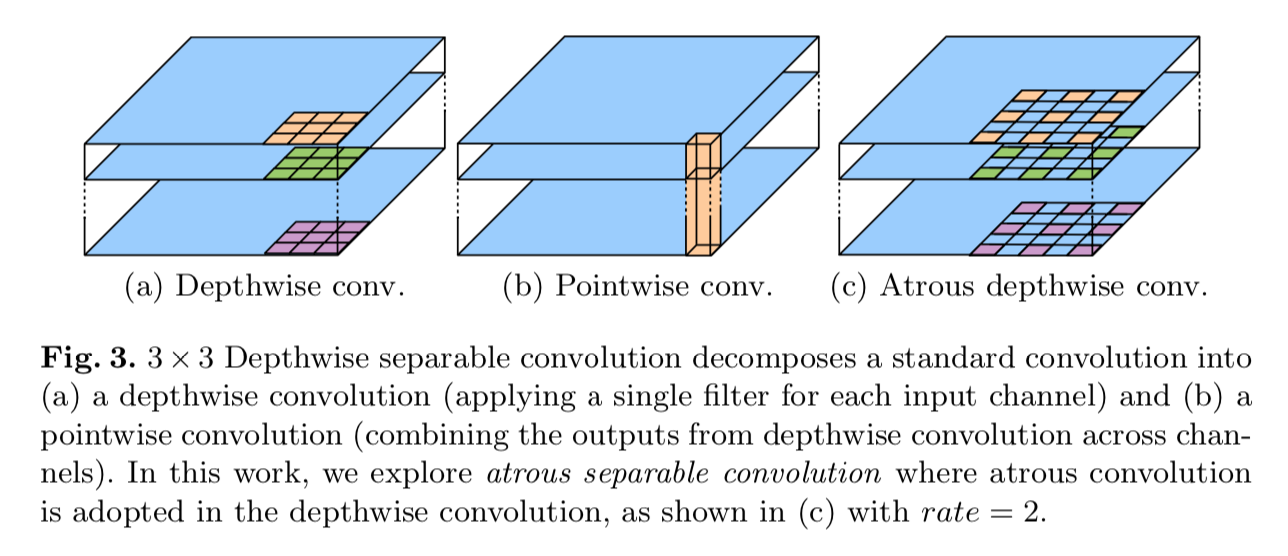

In [14]:
Image.open('assets/fig3.png')

## 第二部分，代码实现

[参考代码github](https://github.com/jfzhang95/pytorch-deeplab-xception), Star 1.5k。

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import math

from resnet import ResNet101

### 需要实现三个子模块
1. Encoder/Backbone
2. ASPP
3. Decoder

最后整合起来

### 1. Encoder/Backbone

resnet.py中ResNet101，注意第120行将底层特征Copy一份最后输出。

In [16]:
net = ResNet101()
x, low_feats = net(torch.rand((1, 3, 128, 128)))
x.size(), low_feats.size()

(torch.Size([1, 2048, 8, 8]), torch.Size([1, 256, 32, 32]))

### 2. ASPP模块

In [17]:
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, 
                                     kernel_size=kernel_size,
                                     padding=padding, 
                                     dilation=dilation,
                                     stride=1, 
                                     bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

class ASPP(nn.Module):
    def __init__(self):
        super(ASPP, self).__init__()
        inplanes = 2048  # resnet101 encoder
        dilations = [1, 6, 12, 18]

        self.aspp1 = _ASPPModule(inplanes, 256, 1, dilation=dilations[0], padding=0)  # padding=dilation使得输出的4个特征图尺寸保持一致
        self.aspp2 = _ASPPModule(inplanes, 256, 3, dilation=dilations[1], padding=dilations[1])
        self.aspp3 = _ASPPModule(inplanes, 256, 3, dilation=dilations[2], padding=dilations[2])
        self.aspp4 = _ASPPModule(inplanes, 256, 3, dilation=dilations[3], padding=dilations[3])

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

### 3. Decoder模块

In [18]:
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        
        low_level_inplanes = 256 #for resnet101 backbone

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

### 整合起来，网络主函数

In [19]:
class DeepLabv3p(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepLabv3p, self).__init__()

        self.backbone = ResNet101()
        self.aspp = ASPP()
        self.decoder = Decoder(num_classes)

    def forward(self, input):
        x, low_level_feat = self.backbone(input)
        print('backbone----x, low_level_feat: ', x.size(), low_level_feat.size())
        x = self.aspp(x)
        print('ASPP output: ', x.size())
        x = self.decoder(x, low_level_feat)
        print('decoder output: ', x.size())
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

In [20]:
net = DeepLabv3p()

In [21]:
for k,v in net.named_parameters():
    print(k)

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.1.conv1.weight
backbone.layer1.1.bn1.weight
backbone.layer1.1.bn1.bias
backbone.layer1.1.conv2.weight
backbone.layer1.1.bn2.weight
backbone.layer1.1.bn2.bias
backbone.layer1.1.conv3.weight
backbone.layer1.1.bn3.weight
backbone.layer1.1.bn3.bias
backbone.layer1.2.conv1.weight
backbone.layer1.2.bn1.weight
backbone.layer1.2.bn1.bias
backbone.layer1.2.conv2.weight
backbone.layer1.2.bn2.weight
backbone.layer1.2.bn2.bias
backbone.layer1.2.conv3.weight
backbone.layer1.2.bn3.weight
backbone.layer1.2.bn3.bias
backbone.layer2.0.conv1.weight
backbone.layer

In [22]:
image = torch.rand((4, 3, 128, 128))

In [23]:
mask = net(image)

backbone----x, low_level_feat:  torch.Size([4, 2048, 8, 8]) torch.Size([4, 256, 32, 32])
ASPP output:  torch.Size([4, 256, 8, 8])
decoder output:  torch.Size([4, 2, 32, 32])


In [24]:
mask.size()

torch.Size([4, 2, 128, 128])